In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Lecture 02: ZTF Summer School 2021

### Michael Coughlin <cough052@umn.edu>

With contributions totally ripped off from Gautham Narayan (UIUC) and Chris Fonnesbeck's PyData course here: https://github.com/fonnesbeck/mcmc_pydata_london_2019

* Simple MC with uniform sampling of parameter space **does not solve curse of dimensionality (too many useless samples in low likelihood region)** 
* What if, instead of sampling the parameter space uniformly, you could sample the posterior directly
    * Possible outcomes would be **simulated with a frequency proportional to the probability**
    
<table>
    <tr>
        <td><img src="figures/Likelihood_Surface.png" width=100%></td>
    </tr>
</table>

There are a couple of approaches to this:
 
### 1. Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

Visually, this corresponds to drawing points that uniformly fill in the space under $p(x)$.

<table>
    <tr>
        <td><img src="figures/mc1_rejection.png" width=100%></td>
    </tr>
</table>
Courtesy: Phil Marshall


# This also does not solve the problem posed by the curse of dimensionality 

# But this approach is general and works for any function 

The second approach you've already seen and used a lot:

### 2. The Inverse Transform 

The definition of the CDF (and it's inverse, $F^{-1}$, the quantile function - i.e. `ppf()` in `scipy.stats`) 

$F(x) = P(X \leq x) = \int_{-\infty}^x p(x')\,dx'$

By this definition, quantiles of $X$ are uniformly distributed on [0,1]. If $F^{-1}$ is easy to evaluate, we can use this straightforwardly:

```
draw u from Uniform(0,1)
compute x = F_inverse(u)
```



<table>
    <tr>
        <td>PDF<img src="figures/mc1_invtrans0.png" width=100%></td>
        <td></td>
        <td>CDF<img src="figures/mc1_invtrans1.png" width=100%></td>
    </tr>
</table>

Courtesy: Phil Marshall

# In class warm-up: The PIT with exponential distributions:

This distribution has $p(x)=\lambda e^{-\lambda x}$ and $F(x)=1-e^{-\lambda x}$ for $x\geq0$.

The quantile function is, therefore, $F^{-1}(P) = -\ln(1-P)/\lambda$.

In [5]:
# Here's some code for the inverse tranform

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def inv_trans_demo(x, lam):
    hist = plt.hist(x, bins=50)
    xs = np.linspace(0.0, 10.0/lam, 100)
    pdf = lam * np.exp(-lam*xs)
    pdfline = plt.plot(xs, pdf, 'r', lw=2)
    plt.xlabel(r'x', fontsize=22)
    plt.ylabel(r'P(x)', fontsize=22);

* for lam = 1., draw a 1000 random samples from a uniform distribution between 0-1 (np.random.rand should do)
* use inverse CDF $F^{-1}(P)$ to convert to samples from a exponential distribution
* then use the demo code to histogram your samples and overplot the distribution.

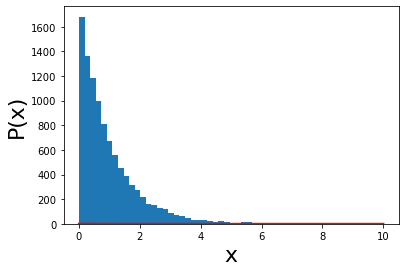

In [5]:
# YOUR CODE HERE
lam = 1.0
u = np.random.rand(10000)
x = -np.log(1.-u)/lam

inv_trans_demo(x, lam)


* This does solve the problem posed by the curse of dimensionality 

* No sample is rejected! 

* The con is that you have to know what p(x) looks like in advance

* If p(x) is your posterior, then you not only need to be able to solve for it analytically (including the evidence - the denominator of Bayes' theorem) but then you've got to figure out how to invert it... even harder.
    
* There is a place for the PIT, but we started down this road because our functions weren't generally going to be nice, so lets deal with rejection sampling some more

# We want a couple of properties

* We want to sample the full distribution 
* We want the frequency of samples between $x$ and $x+dx$ to be proportional to $p(x)dx$

What if, instead of drawing i.i.d samples, we drew samples such that they are correlated with each other.

You have already seen examples of processes where samples are correlated with each other - Brownian motion/random walks/Wiener processes - all of these are examples of **stochastic** processes
<table>
    <tr>
        <td><img src="figures/Wiener_process_3d.png" width=100%></td>
    </tr>
</table>

 What if we chose our samples to be correlated in a very specific way:
   * decide how many samples you want
   * start somewhere - we'll call our current position in k-dimensional parameter space $x$
   * while you want samples:
       * perturb $x$ to $x'$ by some random vector drawn from a fixed distribution   
           * i.e. the samples are correlated
       * evaluate your function at $x'$ and $x$
       * if the function is higher at $x'$ than at $x$ 
           * then yay! Accept it, and set the position $x'$ to the current position $x$
       * else if the function is lower at $x'$ than at $x$
           * well maybe that's bad, or maybe we're just unlucky and there's good samples to be had near here
           * How do we decide? Well let's draw a random number and check if our function ratio is better or worse
               * if it's better, accept and set the position $x'$ to the current position $x$
               * else reject and update the current position to be the same 
       * stick the current position after you did this into a list of samples 
    
This sequence/list of all accepted samples is a **chain**

This is just our **rejection sampling** strategy (recall):

```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Markov Chains:

If we can construct a sequence of samples/chain this way, it will be **ergodic** - i.e. given enough time, the full distribution will be sampled

This chain is from some n-dimensional parameter space, with a distribution that is asymptotically proportional to $p(x)$. 

The constant of proportionality is not important in the first class of problems we will look at. 

In model comparison problems, the proportionality constant must be known. We've glossed over that so far, so we will blithely push forward.

With our particular strategy, every n+1 th position on the chain depends **only** on the nth position:

<table>
    <tr>
        <td><img src="figures/MarkovChain.png" width=100%></td>
    </tr>
</table>

Chains that have this property are called **Markov Chains**.

The **state space** of this stochastic process is the set of all possible values

The particular algorithm for generating new samples (more properly detailed in HW4) is called **Metropolis-Hastings** after the folks that came up with it.

In summary, the Metropolis-Hastings algorithm consists of these steps:

1. given $x$ and $T(x'|x)$, draw a proposed value for $x'$

2. compute acceptance probability $p_{\rm acc}(x,x')$.

3. draw a random number between 0 and 1 from a uniform distribution; if it smaller than $p_{\rm acc}(x,x')$, then accept $x'$.

4. if $x'$ is accepted added it to the chain, if not, add $x'$ to the chain.

See below for why it works!

How far should we step (small steps in parameter space or large). This impacts the efficiency of the process but not if we will reach equilibrium.

<table>
    <tr>
        <td><img src="figures/sampling.png" width=100%></td>
    </tr>
</table>


# WHY DOES Metropolis-Hastings work?

This process is NOT **stationary**. 

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(x') = \int dx \, p(x) \, T(x'|x)$$

where $T(x'|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $x'$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $x'$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!

## Speeding things up

Broadly speaking, we can try to
1. tailor algorithms to specific classes of PDF
2. look for ways to make the general samplers more intelligent

We can also use different samplers for different subsets of parameters - the only rule is that every parameter must get updated somehow.

## Gibbs Sampling
is a specialization of Metropolis-Hastings:
* Instead of making a general proposal in all dimensions, we cycle through the parameters proposing changes to **one at a time**
* A proposal for $\theta_i$ is into the **fully conditional posterior** $p(\theta_i|\theta_{-i},x)$, where $-i$ means all subscripts other than $i$.

Gibbs sampling:
```
while we want more samples
    propose theta1 | theta2, theta3, ..., data
    accept/reject theta1
    propose theta2 | theta1, theta3, ..., data
    accept/reject theta2
    ...
```

### Example: normal PDF

25 Metropolis iterations (left) vs. 25 Gibbs transitions (right)

Color goes blue$\rightarrow$red with time (step number)

<table>
    <tr>
        <td>
            <img src="figures/mc2_metro.png" width=100%>
        </td>
        <td></td>
        <td>
            <img src="figures/mc2_gibbs.png" width=100%>
        </td>
    </tr>
</table>

In general, this is not obviously an improvement to proposing changes to all $\theta$ simultaneously.

Why is a random drunk walking in one specific direction at a time better than just taking a random step???

Something interesting happens if the fully conditional likelihood and prior are **conjugate** 

For some likelihood functions, if you choose a certain prior, *the posterior ends up being in the same distribution as the prior.* Such a prior then is called a **Conjugate Prior.**

i.e. 

# $$ P(\theta) \mathrm{\; such\; that\; } P(\theta|D) = P(\theta) $$


i.e. we know the conditional posterior exactly!

If we use independent samples of the conditional posterior as proposals, then the Metropolis-Hastings acceptance ratio becomes

## $$\frac{p(x')g(x|x')}{p(x)g(x'|x)} = \frac{p(x')p(x)}{p(x)p(x')} = 1$$

**and every proposal is automatically accepted!**

Conjugate Gibbs Sampling:
```
while we want more samples
    draw th1 from p(th1|th2,th3,...,data)
    draw th2 from p(th2|th1,th3,...,data)
    ...
```

* Beta posterior

    * Beta prior * Bernoulli likelihood → Beta posterior
    * Beta prior * Binomial likelihood → Beta posterior
    * Beta prior * Negative Binomial likelihood → Beta posterior
    * Beta prior * Geometric likelihood → Beta posterior

* Gamma posterior
   * Gamma prior * Poisson likelihood → Gamma posterior
   * Gamma prior * Exponential likelihood → Gamma posterior

* Normal posterior
    * Normal prior * Normal likelihood (mean) → Normal posterior

Gibbs Sampling Pros:
* No cycles "wasted" on rejected proposals
* No pesky tuning of the proposal scale

Gibbs Sampling Cons:    
* Only works for conjugate or partially conjugate models (hence must choose conjugate priors)
* Occasionally still slower than proposing multi-parameter Metropolis updates (e.g. when degeneracies are strong)

Some multiple modes:
<table>
    <tr>
        <td>
            Some spectral model<br>
            <img src="figures/mc2_multimode_eg2.png" width=100%>
        </td>
        <td></td>
        <td>
            The eggbox function<br>
            <img src="figures/mc2_eggbox.png" width=100%>
        </td>
    </tr>
</table>

In these cases, when we were talking about optimizers (as opposed to samplers) that used gradient descent, we found that local optimizers got stuck

<table>
    <tr>
        <td>
            Some spectral model<br>
            <img src="figures/global_vs_local.png" width=100%>
        </td>
    </tr>
</table>

We talked about **simulated annealing** and **basin hopping** as examples of *global optimizers* that can get out of these local minima.

With MH, you'd have to make a large step size, but that has a major downside - your acceptance ratio goes down and your autocorrelation time goes up.

So, it's reasonable to ask if there's an analog for MCMC.

## Tempering
Consider the function $[p(x)]^{1/T}$, where $p(x)$ is the target PDF.
* We say a chain sampling this function has temperature $T$. For $T>1$, $p^{1/T}$ is smoothed out compared with $p$.
    * This is the same sort of thing that we saw with **simulated annealing** - start with sampling at a high temperature and then gradually lower the temperature with some schedule
* This allows chains to move among multiple peaks more easily.
* Of course, we're only actually interested in $T=1$...

### Parallel tempering

With parallel tempering, we run one chain with $T=1$ and several more chains with $T>1$. A modified Metropolis-Hastings update occasionally allows the chains to exchange positions, giving the $T=1$ chain a mechanism for sampling regions of parameter space it might otherwise have low probability of proposing. Samples from the $T=1$ chain can be used for inference.

## Coping with multiple modes

Multiple, well separated posterior modes are a serious challenge for many samplers.
* In general, the only way to discover that they exist is by exploring the parameter space with many widely dispersed chains.
* To do inference, our chains need to be able to efficiently transition between modes - so far the most reliable general method we've seen for this is parallel tempering. 

## Implementations of other samplers that are commonly used in research:

1. Gibbs Sampling ([pymc3](https://docs.pymc.io/))
2. Parallel Tempering (now in [ptemcee](https://pypi.org/project/ptemcee/))
3. Hamiltonian Monte Carlo/No U-turn Sampling (also [pymc3](https://docs.pymc.io/))

And this is also a sampler, but is not actually a Markov Chain method (Monte Carlo is logically separate from Markov Chain Monte Carlo)
4. Nested Sampling ([dynesty](https://dynesty.readthedocs.io/en/latest/index.html) or [Multinest](https://johannesbuchner.github.io/PyMultiNest/))


We can't cover all of these, but you should have a good idea on how to start with any of them by now, and which one to pick for a particular problem.

## In Class warm-up: think

Recall the ugly PDF features we were motivated by, namely strong/nonlinear degeneracies and multiple modes.
For each of the methods above, do you expect an improvement compared with standard Metropolis in these situations. 

Why and for which methods?

<table>
    <tr>
        <td>
            <img src="figures/mc2_rosenbrock.png" width=80%>
        </td>
        <td></td>
        <td>
            <img src="figures/mc2_eggbox.png" width=80%>
        </td>
    </tr>
</table>

# In Class warm-up:

Here are some simple functions. Use my MH sampling code to sample them, and compare to what you get on a grid of x, y

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def Rosenbrock_lnP(x, y, a=1.0, b=100.0):
    if y < 0.0: return -np.inf
    return -( (a-x)**2 + b*(y-x**2)**2 )

def eggbox_lnP(x, y):
    return (2.0 + np.cos(0.5*x)*np.cos(0.5*y))**3

def sphshell_lnP(x, y, s=0.1):
    return -(np.sqrt(x**2+y**2) - 1)**2/(2.0*s**2)


In [2]:
def metropolis_hastings(p, x0, sigma, *args, nsamp=1000):
    
    ndim = len(x0)
    try:
        test_val = p(*x0, *args)
        if not np.isfinite(test_val):
            raise ValueError('Function at starting position is not finite')
        
        if test_val == 0.:
             raise ValueError('Function at starting position must be non-zero')
                
    except Exception as e:
        message = f'{e}\nCannot initialize sampler at this position'
        raise ValueError(message)
    
        
    # we need something to save the samples we want
    samples = np.zeros((nsamp, ndim))    

    x = np.array(x0)
    sigma = np.array(sigma)
    
    # the position and step size arrays had better be the same 
    assert x.shape == sigma.shape, 'Shape of x and shape of sigma must be the same'
    
    # while we want more samples
    for i in range(nsamp):

        # now we adjust the initial position a little
        # instead of explictly definition g(x|x') and g(x'|x)
        # we can recognize that a Gaussian is a stationary kernel
        # as we discussed in class, this is nice because 
        # all that matters is the absolute difference between x' and x
        # and if that's the case, then g(x'|x) = g(x|x')
        x_prime = x + sigma*np.random.randn(ndim)


        if np.random.rand() < (p(*x_prime, *args) / p(*x, *args)):
            x = x_prime
            
        # we save the sample to the chain
        samples[i] = x
    return samples




def mh_demo(p, x0, sigma, nsamp=1000):
    samples = metropolis_hastings(p, x0, sigma, nsamp=nsamp)

    
    # create some axes
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax0, ax1, ax2 = axs
    
    # plot all the data in grey
    ax0.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.1, marker='.')
    ax1.plot(samples[:, 0], marker='.', color='grey', alpha=0.1, ls='-')
    ax2.plot(samples[:, 1], marker='.', color='grey', alpha=0.1, ls='-')
    return fig
    

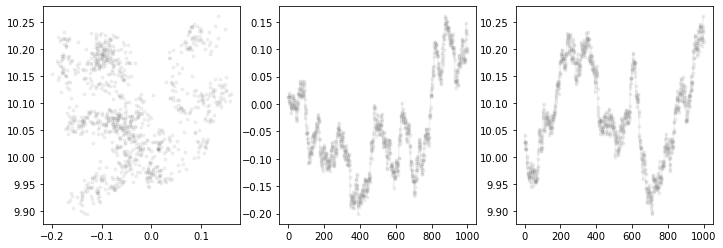

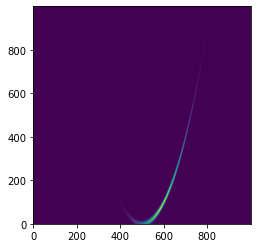

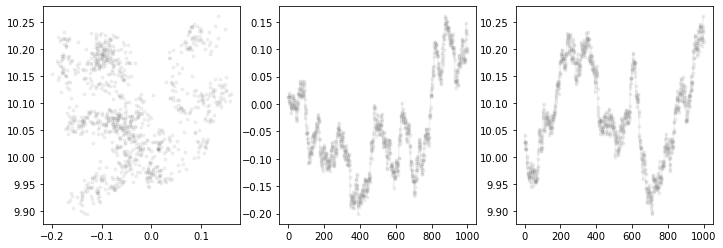

In [9]:
# Your code here

x = np.arange(-5, 5, 0.01)
y = np.arange(0, 10, 0.01)
X, Y = np.meshgrid(x, y)
f = np.vectorize(Rosenbrock_lnP)
val = f(X, Y)
%matplotlib inline
plt.imshow(np.exp(val), origin='lower')

mh_demo(Rosenbrock_lnP, [0, 10], [0.01, 0.01] )

# In class Exercise:

Now let's try fitting a line.

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astropy.stats import sigma_clip
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

keep = np.ones(len(x), dtype='bool')
keep[0:4] = False
x, y, dy = x[keep], y[keep], dy[keep]

Text(0, 0.5, 'y')

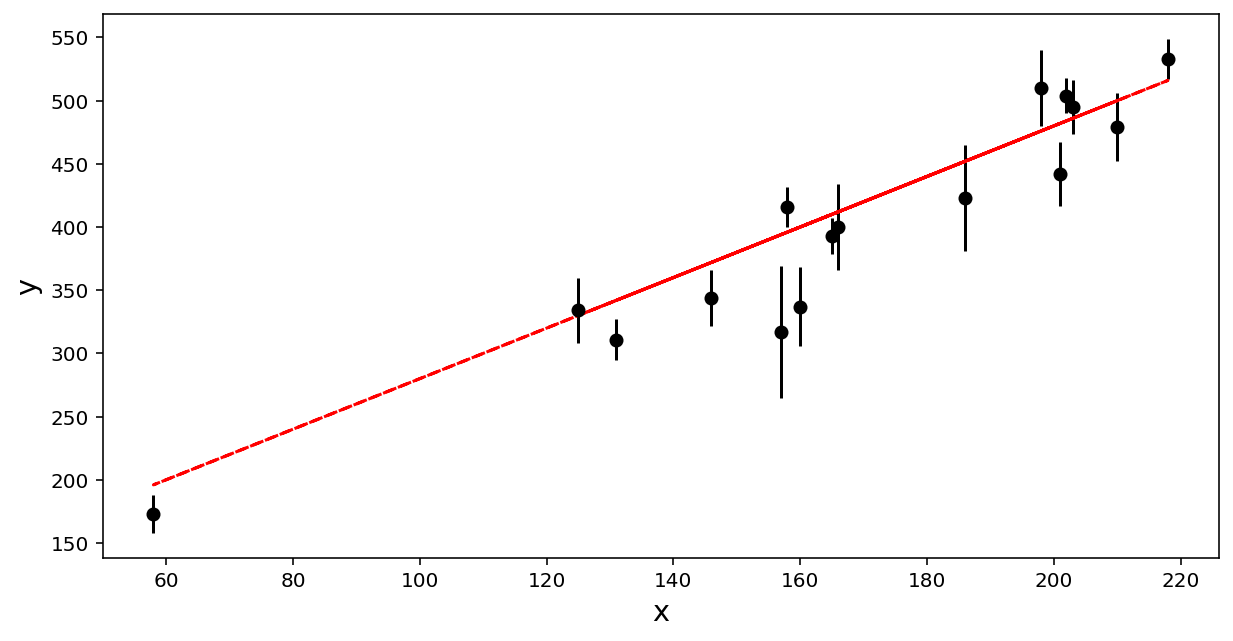

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x, y, yerr=dy, color='k', marker='o', linestyle='None', label='All data')
plt.plot(x, 80 + 2*x, 'r--')

ax.set_xlabel('x', fontsize='x-large')
ax.set_ylabel('y', fontsize='x-large')


This function calculates the joint log-posterior, conditional on values for each parameter:

In [16]:
from scipy.stats import norm
dnorm = norm.logpdf

def calc_posterior(a, b, y=y, x=x, dy=dy):
    # Calculate joint posterior, given values for a and b

    # YOUR CODE HERE
    # Priors on a,b
    logp = dnorm(a, 80, 40) + dnorm(b, 2, 1)
    # Calculate mu
    mu = a + b*x
    # Data likelihood (I suggest norm.logpdf...)
    logp += sum(dnorm(y, mu, dy))
    
    return logp

So many metropolis implementations out there...

In [17]:
rnorm = np.random.normal
runif = np.random.rand
np.random.seed(42)

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

Try running the MH algorithm with a small proposal variance, say: 0.001:

In [18]:
n_iter = 5000

# YOUR CODE HERE
# trace, acc = metropolis( ...
trace, acc = metropolis(n_iter, (80,2), 0.001)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000


We can see that the acceptance rate is way too high... why?!

In [19]:
np.array(acc, float)/n_iter

array([0.9996, 0.9904])

We can also plot the samples to watch the algorithm.

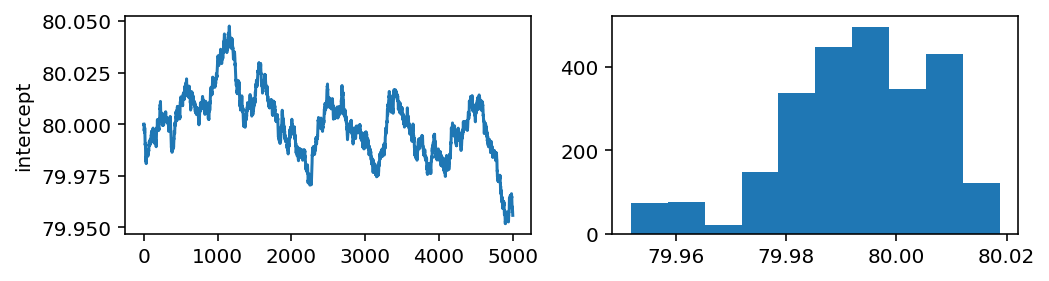

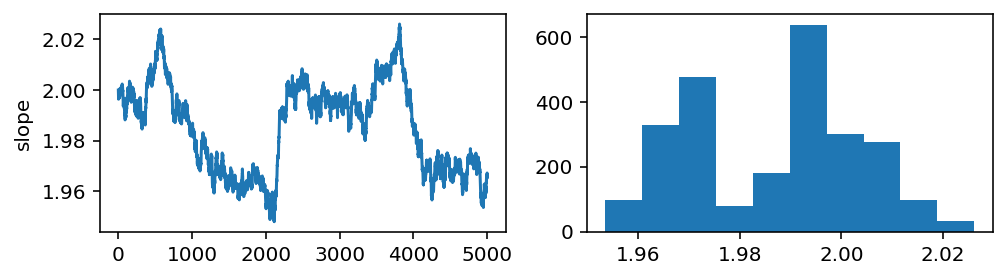

In [164]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

Try plotting the fits on top of the data to see how it looks... what do you notice?

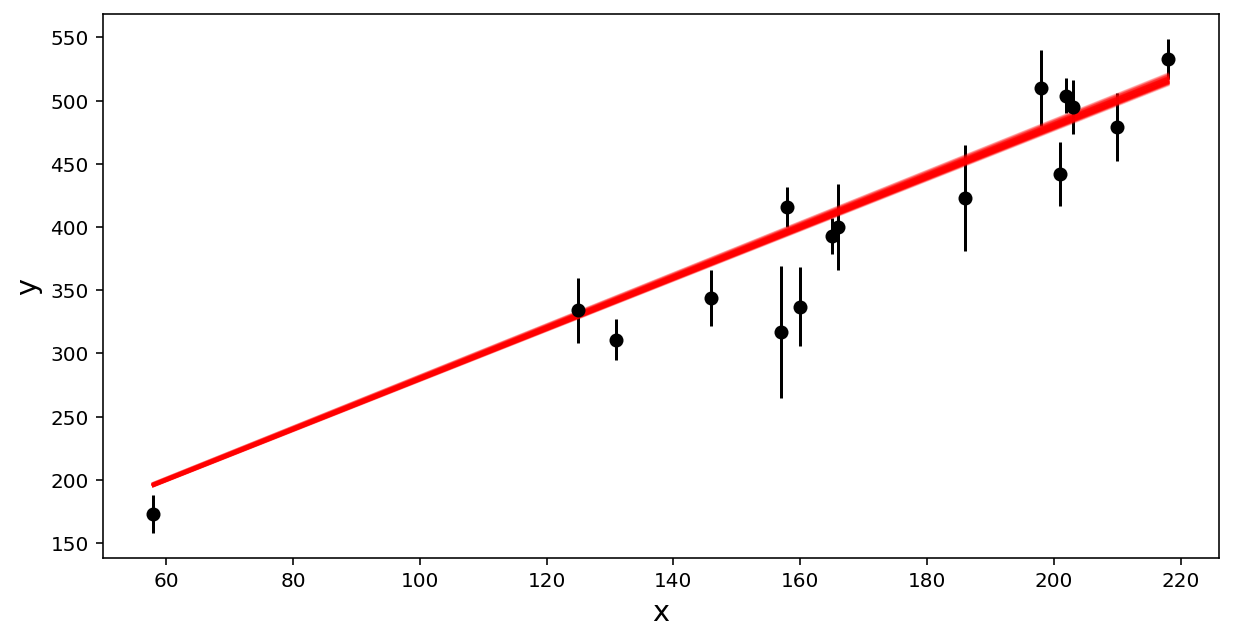

In [165]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x, y, yerr=dy, color='k', marker='o', linestyle='None', label='All data')

ax.set_xlabel('x', fontsize='x-large')
ax.set_ylabel('y', fontsize='x-large')

xvals = np.linspace(x.min(), x.max())
for i in range(50):
    b0,b1= trace[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

Now, try with a very large proposal variance (10):

In [21]:
# YOUR CODE HERE
# trace_hivar, acc = metropolis( ...
trace_hivar, acc = metropolis(n_iter, (80,2), 10)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000


In [22]:
np.array(acc, float)/n_iter

array([0.5054, 0.0036])

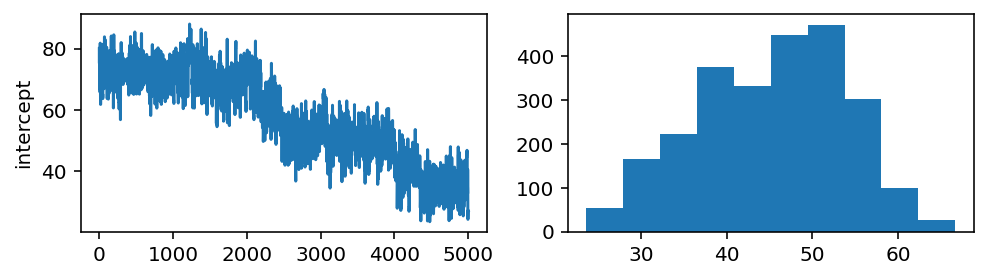

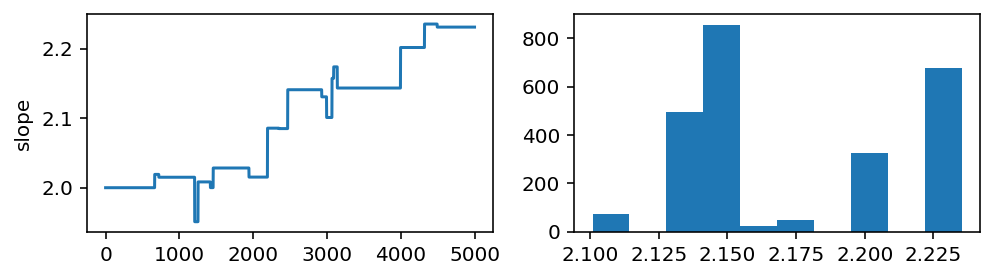

In [23]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_hivar.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

Try plotting the fits on top of the data to see how it looks... what do you notice?

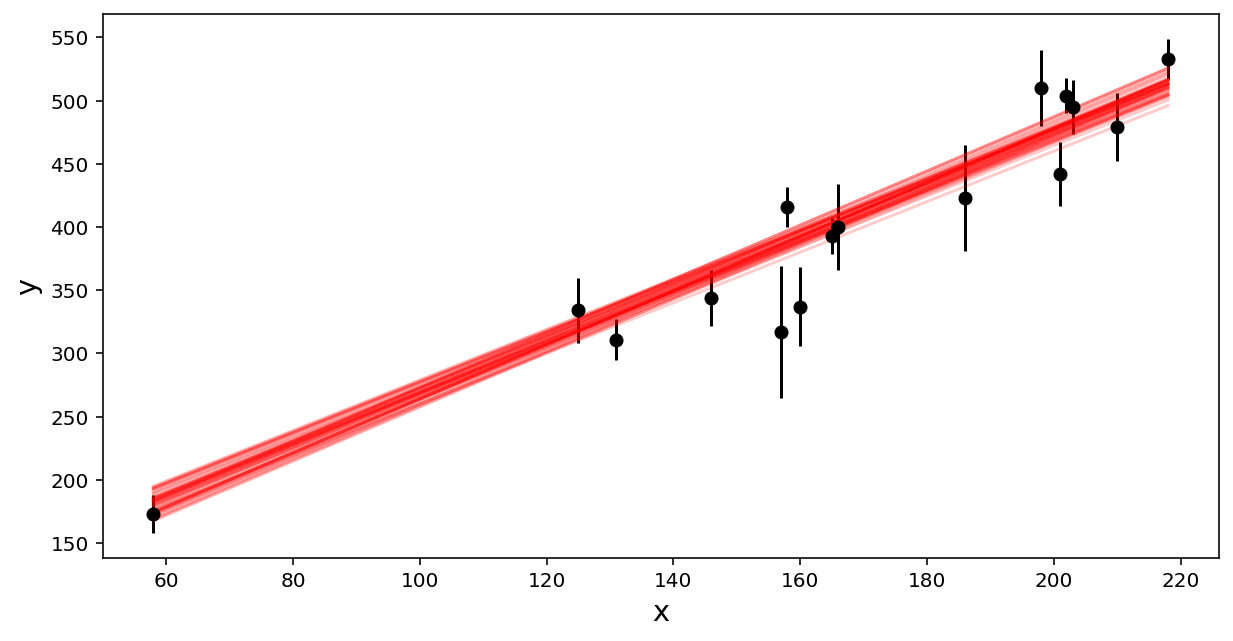

In [134]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x, y, yerr=dy, color='k', marker='o', linestyle='None', label='All data')

ax.set_xlabel('x', fontsize='x-large')
ax.set_ylabel('y', fontsize='x-large')

xvals = np.linspace(x.min(), x.max())
for i in range(50):
    b0,b1 = trace_hivar[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

Can you find a variance that gives you ~25%?

In [24]:
# YOUR CODE HERE

In order to avoid having to set the proposal variance by trial-and-error, we can add some tuning logic to the algorithm. 

## Auto-tuning Metropolis-Hastings

We can modify the Metropolis-Hastings algorithm above by adding logic to automatically change the proposal scale depending on the acceptance rate of the chain. 

In [26]:
def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
     
    n_params = len(initial_values)
             
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
     
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
     
    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params
     
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
     
    if tune_for is None:
        tune_for = n_iterations/2
     
    for i in range(n_iterations):
     
        if not i%1000: print('Iteration %i' % i)
     
        # Grab current parameter values
        current_params = trace[i]
     
        for j in range(n_params):
     
            # Get current value for parameter j
            p = trace[i].copy()
     
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
             
            # Insert new value 
            p[j] = theta
     
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
     
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
     
            # Sample a uniform random variate
            u = runif()
     
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                 
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
         
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.4:
                    prop_sd[j] *= 1.1
                accepted[j] = 0
                 
    return trace[tune_for:], accepted

In [27]:
trace_tuned, acc = metropolis_tuned(10000, (80,2), tune_for=5000)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [28]:
np.array(acc, float)/5000

array([0.2974, 0.2796])

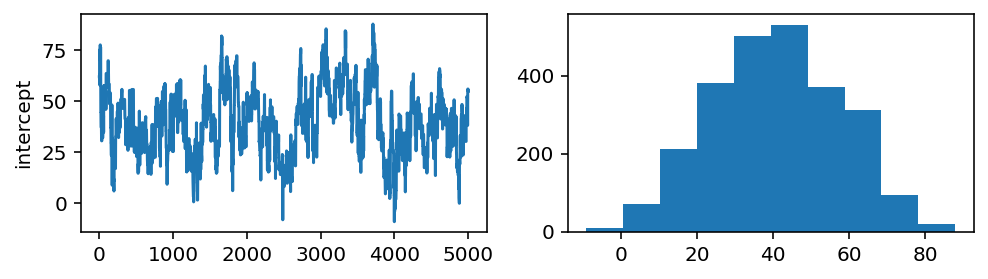

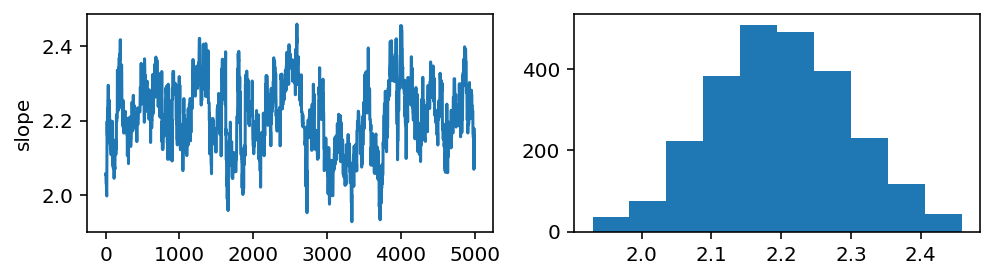

In [29]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

And now to see how it performs:

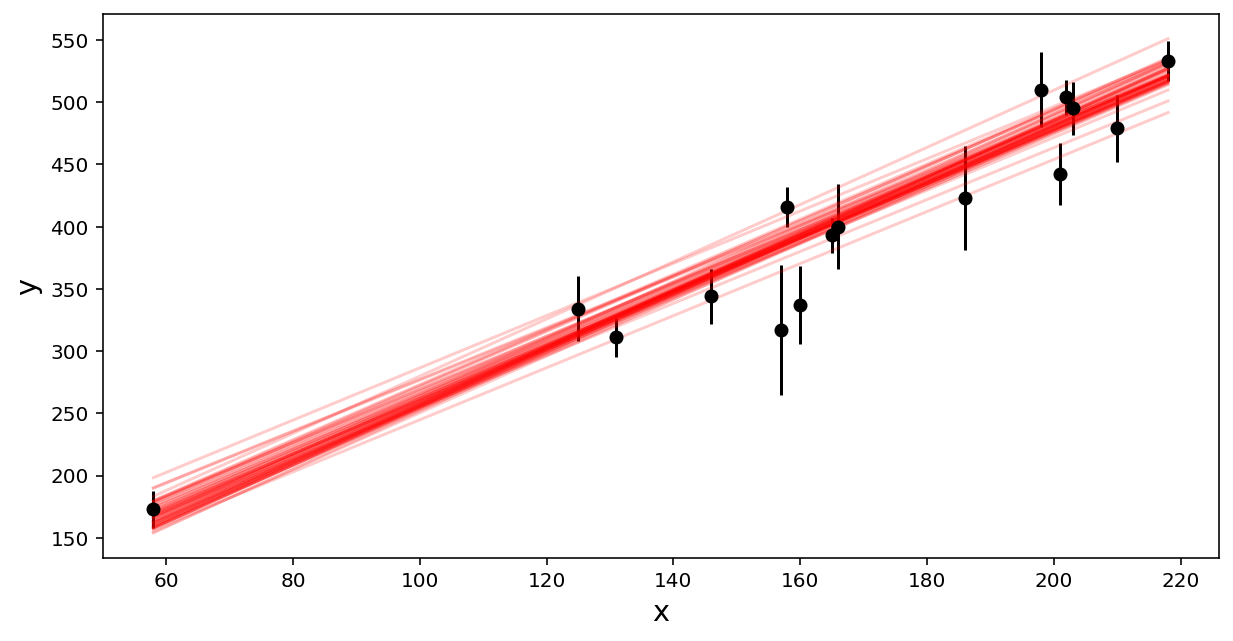

In [30]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x, y, yerr=dy, color='k', marker='o', linestyle='None', label='All data')

ax.set_xlabel('x', fontsize='x-large')
ax.set_ylabel('y', fontsize='x-large')

xvals = np.linspace(x.min(), x.max())
for i in range(50):
    b0,b1 = trace_tuned[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

# Appendix: Hamiltonian Monte Carlo

While flexible and easy to implement, Metropolis-Hastings sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

(*image: Hoffman and Gelman, 2014*)

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that samples from the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.

### What's a Typical Set?

The typical set is where most of the probability lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![](figures/typical_set_.png)

(image: Betancourt 2017)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

### Simulating Hamiltonian Dynamics

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$.

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

The Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

![](images/skate_park.jpg)

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

## Example: Normal mixture

HMC as implemented in PyMC3 is heavily automated. To provide some innsight into how the components of HMC work, let's look at a simpler implementation provided by [`minimc`](https://github.com/ColCarroll/minimc), a package created by Colin Carroll. This can be used to illustrate leapfrog integration and the paths taken for HMC sampling.

The example we will employ here is a mixture of three bivariate normal distribution, each with its own location and covariance. 

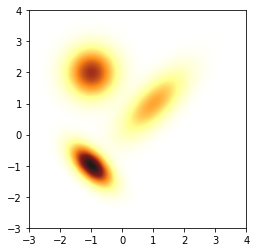

In [7]:
# pip install git+git://github.com/colcarroll/minimc.git
%matplotlib inline
import matplotlib.pyplot as plt

from autograd import grad
import autograd.numpy as np
from minimc import mixture, neg_log_mvnormal

# Plotting helper function
def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-3, 3, -3, 3)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent

np.random.seed(7)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([-1., 2.])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), 
                     neg_log_mvnormal(mu2, cov2), 
                     neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)

plt.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='lower')

Though simple, this would be very challenging for a Metropolis sampler, which would have a great deal of difficulty crossing the areas of low probabilities between the peaks. Most of the time, you would end up with an estimate of one of the three components, leaving the others entirely unexplored.

### Leapfrog Integration

We can explore the paths taken by HMC samplers by simulating from a leapfrog integrator, which varies by the amount of momentum and the size and number of steps taken.

In [8]:
from minimc.minimc_slow import leapfrog, hamiltonian_monte_carlo
from minimc import neg_log_mvnormal

dVdq = grad(neg_log_p)

steps = slice(None, None, 40)

positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, position, momentum, _ = leapfrog(q, p, dVdq, 4 * np.pi, 0.01)
    positions.append(position)
    momentums.append(momentum)

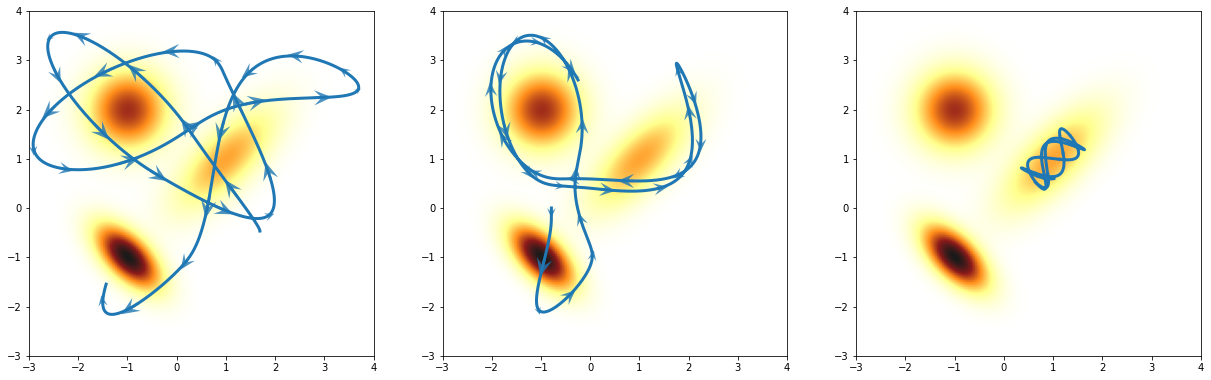

In [9]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(7 * len(positions), 7))

steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='lower')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, 
              scale=60, headlength=7, alpha=0.8, color='C0')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='C0')

# In-class exercise: Let's apply this to microlensing (also on your homework!)

In this tutorial, we will model the light curve of microlensing event ZTF19aavisrq that was detected by ZTF.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

In [3]:
# Reading data from a text file

time, mag, magerr = np.loadtxt('data/ZTF19aavisrq.dat', unpack=True, usecols=(0, 1, 2))
time -= 2450000.0

Plot your data! (always a good idea...)

<IPython.core.display.Javascript object>


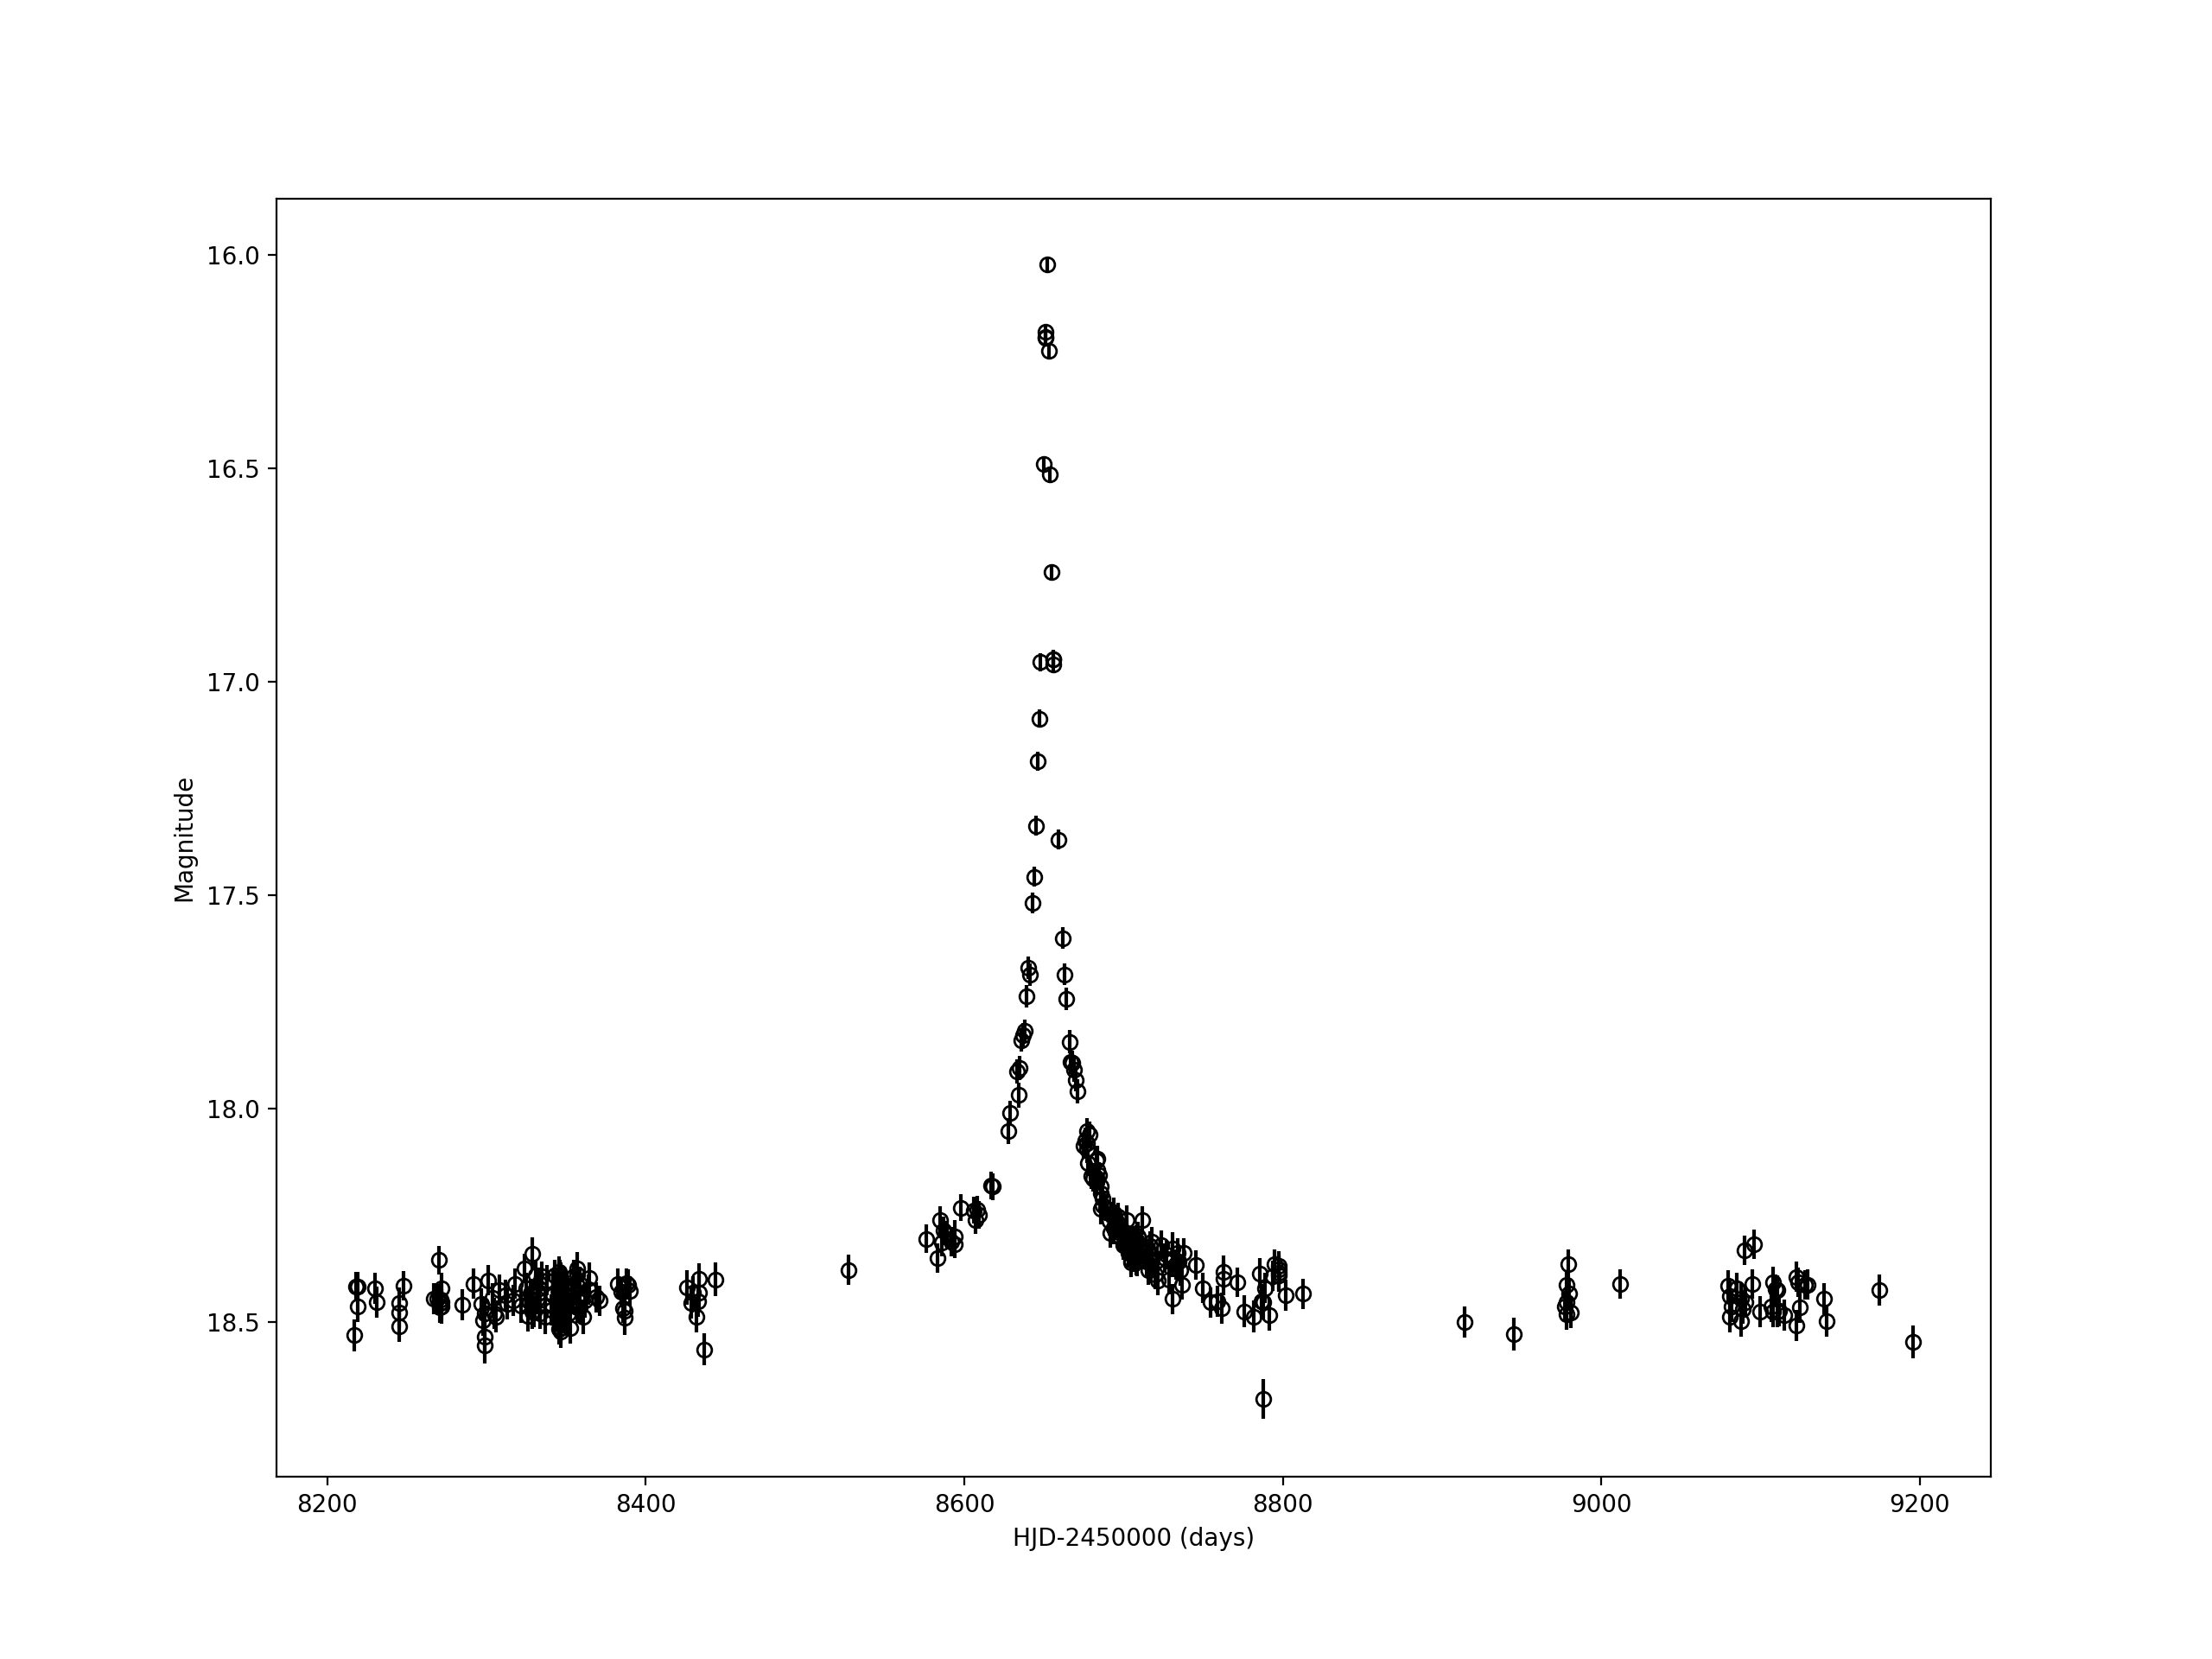

In [5]:
fig, ax = plt.subplots()
ax.errorbar(time, mag, magerr, fmt='o', mfc='none', color='k')
ax.invert_yaxis()
ax.set_xlabel('HJD-2450000 (days)')
ax.set_ylabel('Magnitude')
plt.show()

Every microlensing event has a characteristic angular scale, which we call the angular Einstein radius $\theta_E$. The Einstein radius depends on the mass of the lens $M$, the distance of the lens $d_L$, and the distance to the source $d_S$:
$$
\theta_E = \sqrt{\frac{4GM}{c^2}\frac{d_S-d_L}{d_S d_L}}.
$$
Calculate the Einstein radius for a typical lens that has a mass of $0.5\,M_{\odot}$ and is located 4 kpc from the observer. Assume that the source star is located in the Galactic bulge at 8 kpc.

In [ ]:
# ....

In the simplest case, when the lens is an isolated object and the source star can be regarded as a point, the magnification of the source depends on the lens-source separation $\theta$ scaled to $\theta_E$:
$$
A(u) = \frac{u^2+2}{u\sqrt{u^2+4}},
$$
where $u=\theta/\theta_E$. This function has several important properties. $A(u)$ is always greater than 1, so microlensing can only increase the brightness of the source star, not decrease it. $A(u)$ always decreases as $u$ increases, so the closer the alignment, the brighter the source becomes. As $u$ approaches infinity, $A(u)$ approaches 1, so that at wide separations, microlensing has no effect. Finally, as $u$ approaches 0, for a point source $A(u)$ approaches infinity as the images approach an Einstein ring. 

The lens-source separation $u$ varies with time. The function $u(t)$ can be determined by the Pythagorean theorem:
$$
u(t) = \sqrt{u_0^2 + \tau(t)^2} = \sqrt{u_0^2+\left(\frac{t-t_0}{t_E}\right)^2},
$$
where $u_0$ is the minimum lens-source separation, $t_0$ is the time of the peak, and $t_E$ is called the Einstein time. $t_E$ is the time it takes the lens to transverse an angular distance $\theta_E$ relative to the source.

![title](img/geom_Aofu.png)

The amplitude of the event depends on the impact parameter $u_0$. Plot the function $u_0=u_0(A_{\rm max})$.

In [ ]:
# ...

Our lensing model has three parameters: $t_0$ -- time of the peak, $t_E$ -- Einstein timescale, and $u_0$ -- impact parameter. There are two auxialiary parameters: $F_s$ -- flux of the source star (that is magnified during the event) and $F_b$ -- blended flux, which may come from unrelated unresolved stars and/or the lens itself. The blend flux is not magnified during the event. The total flux is:
$$
F(t) = F_s A(t; t_0,t_E,u_0) + F_b.
$$

We will find the best-fit parameters by minimizing the function $\chi^2$, which is the sum of squares of residuals between the observations and model predictions:
$$
\chi^2 = \sum_{i=1}^N \frac{(F_i-F(t_i))^2}{\sigma_i^2} = \sum_{i=1}^N \frac{(F_i-F_s A(t_i;t_0,t_E,u_0)-F_b)^2}{\sigma_i^2}
$$

Our model is linear in $F_s$ and $F_b$. This means that for every set of $(t_0,t_E,u_0)$, we can directly find $F_s$ and $F_b$ that minimize $\chi^2$. We require:
$$
\frac{\partial\chi^2}{\partial F_s} = 0\ \mathrm{and} \ \frac{\partial\chi^2}{\partial F_b} = 0.
$$

Thus (you can prove that!):
$$
F_s \sum_{i=1}^N \frac{A(t_i)^2}{\sigma_i^2} + F_b \sum_{i=1}^N \frac{A(t_i)}{\sigma_i^2} = \sum_{i=1}^N \frac{A(t_i)F_i}{\sigma_i^2}\\
F_s \sum_{i=1}^N \frac{A(t_i)}{\sigma_i^2} + F_b \sum_{i=1}^N \frac{1}{\sigma_i^2} = \sum_{i=1}^N \frac{F_i}{\sigma_i^2}\\
$$

We now have all ingredients needed to code the function $\chi^2$.

In [6]:
def amplification(params, time):
    assert len(params) == 3
    t_0, t_E, u_0 = params
    tau = (time-t_0)/t_E
    u = np.sqrt(tau*tau + u_0*u_0)
    A = (u*u+2.0)/u/np.sqrt(u*u+4.0)
    return A

def get_fluxes(params, time, flux, flux_err):
    A = amplification(params, time)
    weight = 1.0/(flux_err*flux_err)
    sum1 = np.sum(A*A*weight)
    sum2 = np.sum(A*weight)
    sum3 = np.sum(weight)
    sum4 = np.sum(A*flux*weight)
    sum5 = np.sum(flux*weight)
    F = np.linalg.solve([[sum1, sum2], [sum2, sum3]], [sum4, sum5])
    residuals = (flux-F[0]*A-F[1])/flux_err
    chi_squared = np.sum(residuals*residuals)
    return chi_squared, F, residuals

def chi2(params, time, flux, flux_err):
    chi_squared, F, residuals = get_fluxes(params, time, flux, flux_err)
    return chi_squared

## $\chi^2$ minimization with the Nelder-Mead algorithm
Let's fit some data! First, we need to convert magnitudes to flux. We use the Pogson law and assume that a unit flux corresponds to a 18 mag object.

In [7]:
flux = pow(10.0, 0.4*(18.0-mag))
flux_err = 0.4*np.log(10.0)*flux*magerr

We now use scipy's minimize function to find ($t_0,t_E,u_0$) that minimize our $\chi^2$ function. We have to choose initial guess parameters. For example, for $t_0=8652$, $t_E=50$ days and $u_0=0.05$, we get $\chi^2=1233.2$.

In [8]:
params0 = np.array([8652., 50., 0.05])
chi_sq = chi2(params0, time, flux, flux_err)
print(chi_sq)

1233.1875593077625


In [9]:
res = minimize(
    chi2,  # function to be minimized
    params0,  # initial guess
    args=(time, flux, flux_err),  # extra arguments passed to the objective function
    method='Nelder-Mead',  # minimization algorithm
)

print(res)

 final_simplex: (array([[8.65181355e+03, 8.91671423e+01, 1.78801632e-02],
       [8.65181355e+03, 8.91672147e+01, 1.78801449e-02],
       [8.65181355e+03, 8.91671120e+01, 1.78801730e-02],
       [8.65181355e+03, 8.91671877e+01, 1.78801450e-02]]), array([464.11562406, 464.11562406, 464.11562406, 464.11562406]))
           fun: 464.11562405801016
       message: 'Optimization terminated successfully.'
          nfev: 237
           nit: 127
        status: 0
       success: True
             x: array([8.65181355e+03, 8.91671423e+01, 1.78801632e-02])


Let's plot the best-fitting model

[0.10011119 0.56057475]


<IPython.core.display.Javascript object>


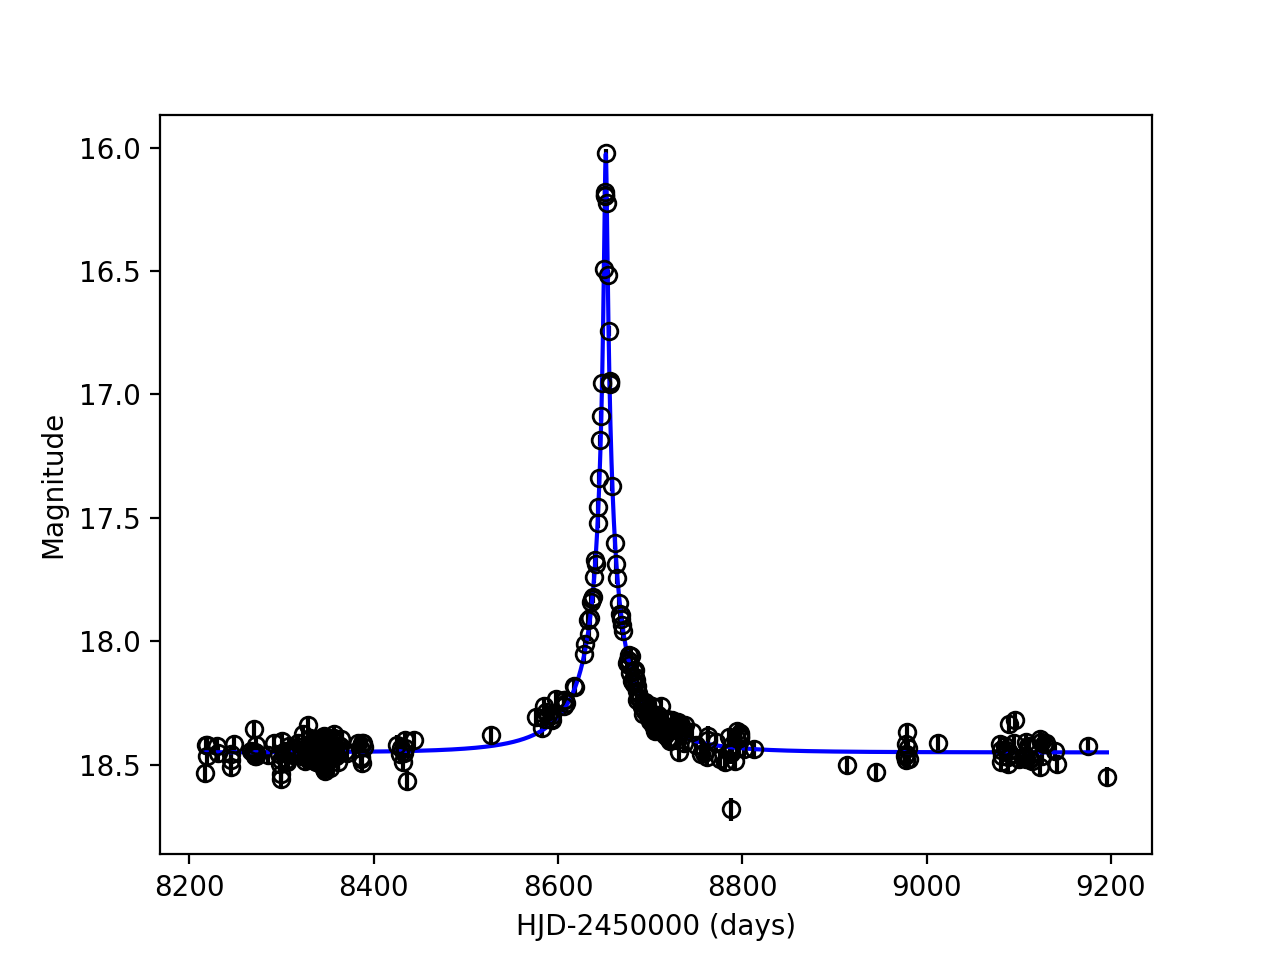

In [10]:
# get source and blend fluxes:
chi_sq, F, residuals = get_fluxes(res.x, time, flux, flux_err)
print(F)

time_model = np.linspace(time[0], time[-1], 5000)
A_model = amplification(res.x, time_model)
flux_model = F[0]*A_model + F[1]
mag_model = 18.0 - 2.5*np.log10(flux_model)

fig, ax = plt.subplots()
ax.errorbar(time, mag, magerr, fmt='o', mfc='none', color='k')
ax.plot(time_model, mag_model, color='blue')
ax.invert_yaxis()
ax.set_xlabel('HJD-2450000 (days)')
ax.set_ylabel('Magnitude')
plt.show()

## Using least-squares methods
The minimization can be also performed using the least squares method. We'll use the Levenberg-Marquardt algorithm as an example, but we have to modify our objective function.

In [11]:
def get_residuals(params, time, flux, flux_err):
    chi_squared, F, residuals = get_fluxes(params, time, flux, flux_err)
    return residuals

ls_res = least_squares(
    get_residuals,
    params0,
    method='lm',
    args=(time, flux, flux_err),
)

print(ls_res)

 active_mask: array([0, 0, 0])
        cost: 232.05781202905908
         fun: array([-2.25523818e+00,  8.87369774e-01,  8.87252238e-01, -4.33460205e-01,
        7.53111780e-01, -1.26615284e-01, -1.84536536e-01, -1.71366246e+00,
       -8.11648604e-01,  9.38636951e-01,  8.97115167e-02,  6.15811103e-02,
        2.62714218e+00, -4.70170375e-01,  3.00874627e-02, -1.90826647e-01,
        7.95239790e-01, -1.17421693e-01, -3.88273843e-01, -3.32723509e-01,
        1.06752424e+00, -2.51872974e-01, -1.29932828e+00, -8.51362621e-01,
       -2.61645496e+00, -2.10784172e+00,  1.28483464e+00,  1.07941177e-01,
       -8.81023948e-01, -1.07687049e+00,  6.27969747e-01,  2.98402861e-01,
       -2.85151348e-01, -3.52729945e-02,  1.05910885e+00, -3.52021773e-01,
        2.03403865e+00,  7.30405490e-01, -1.02835209e+00, -1.50764915e-01,
        3.74612089e-01, -4.03936714e-01,  2.71852288e+00, -7.02969218e-01,
       -7.79390014e-01,  1.60071338e+00,  4.18649667e-02,  1.10801442e+00,
        6.78603993e-01

Note that this function converges much more quickly that the $\chi^2$ minimization algorithm (Nelder-Mead algorithm). It required only 30 evaluations of the objective function (whereas the Nelder-Mead algorithm needed 237 function evaluations!) If the calculation of the objective function is computationally costly, least-squares method are much more quicker! You can test other algorithms by changing the method argument: Trust Region Reflective algorithm (method='trf') and dogleg algorithm (method='dogbox'). You can also speed up calculations by providing the Jacobian matrix.

## Uncertainties
We will use the Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler coded by Foreman-Mackey et al. to measure parameter uncertainties

In [14]:
import emcee
import corner

In [15]:
def log_prior(params):
    if params[1] < 0:
        return -np.inf
    if params[2] < 0:
        return -np.inf
    return 0.0

def log_prob(params, time, flux, flux_err):
    chi_squared, F, residuals = get_fluxes(params, time, flux, flux_err)
    prior = log_prior(params)
    if np.isinf(prior):
        return -np.inf
    return -0.5*chi_squared + prior

In [16]:
ndim = 3  # number of dimensions
nwalkers = 100  # number of walkers
nburnin = 3000
nsteps = 2000

p0 = np.random.multivariate_normal(res.x, cov=np.diag([1.0, 5.0, 0.00001]), size=nwalkers)

In [17]:
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_prob,
    args=[time, flux, flux_err]
)

In [18]:
state = sampler.run_mcmc(p0, nburnin)
sampler.reset()

In [19]:
state = sampler.run_mcmc(state, nsteps)

In [20]:
samples = sampler.get_chain(flat=True)

<IPython.core.display.Javascript object>


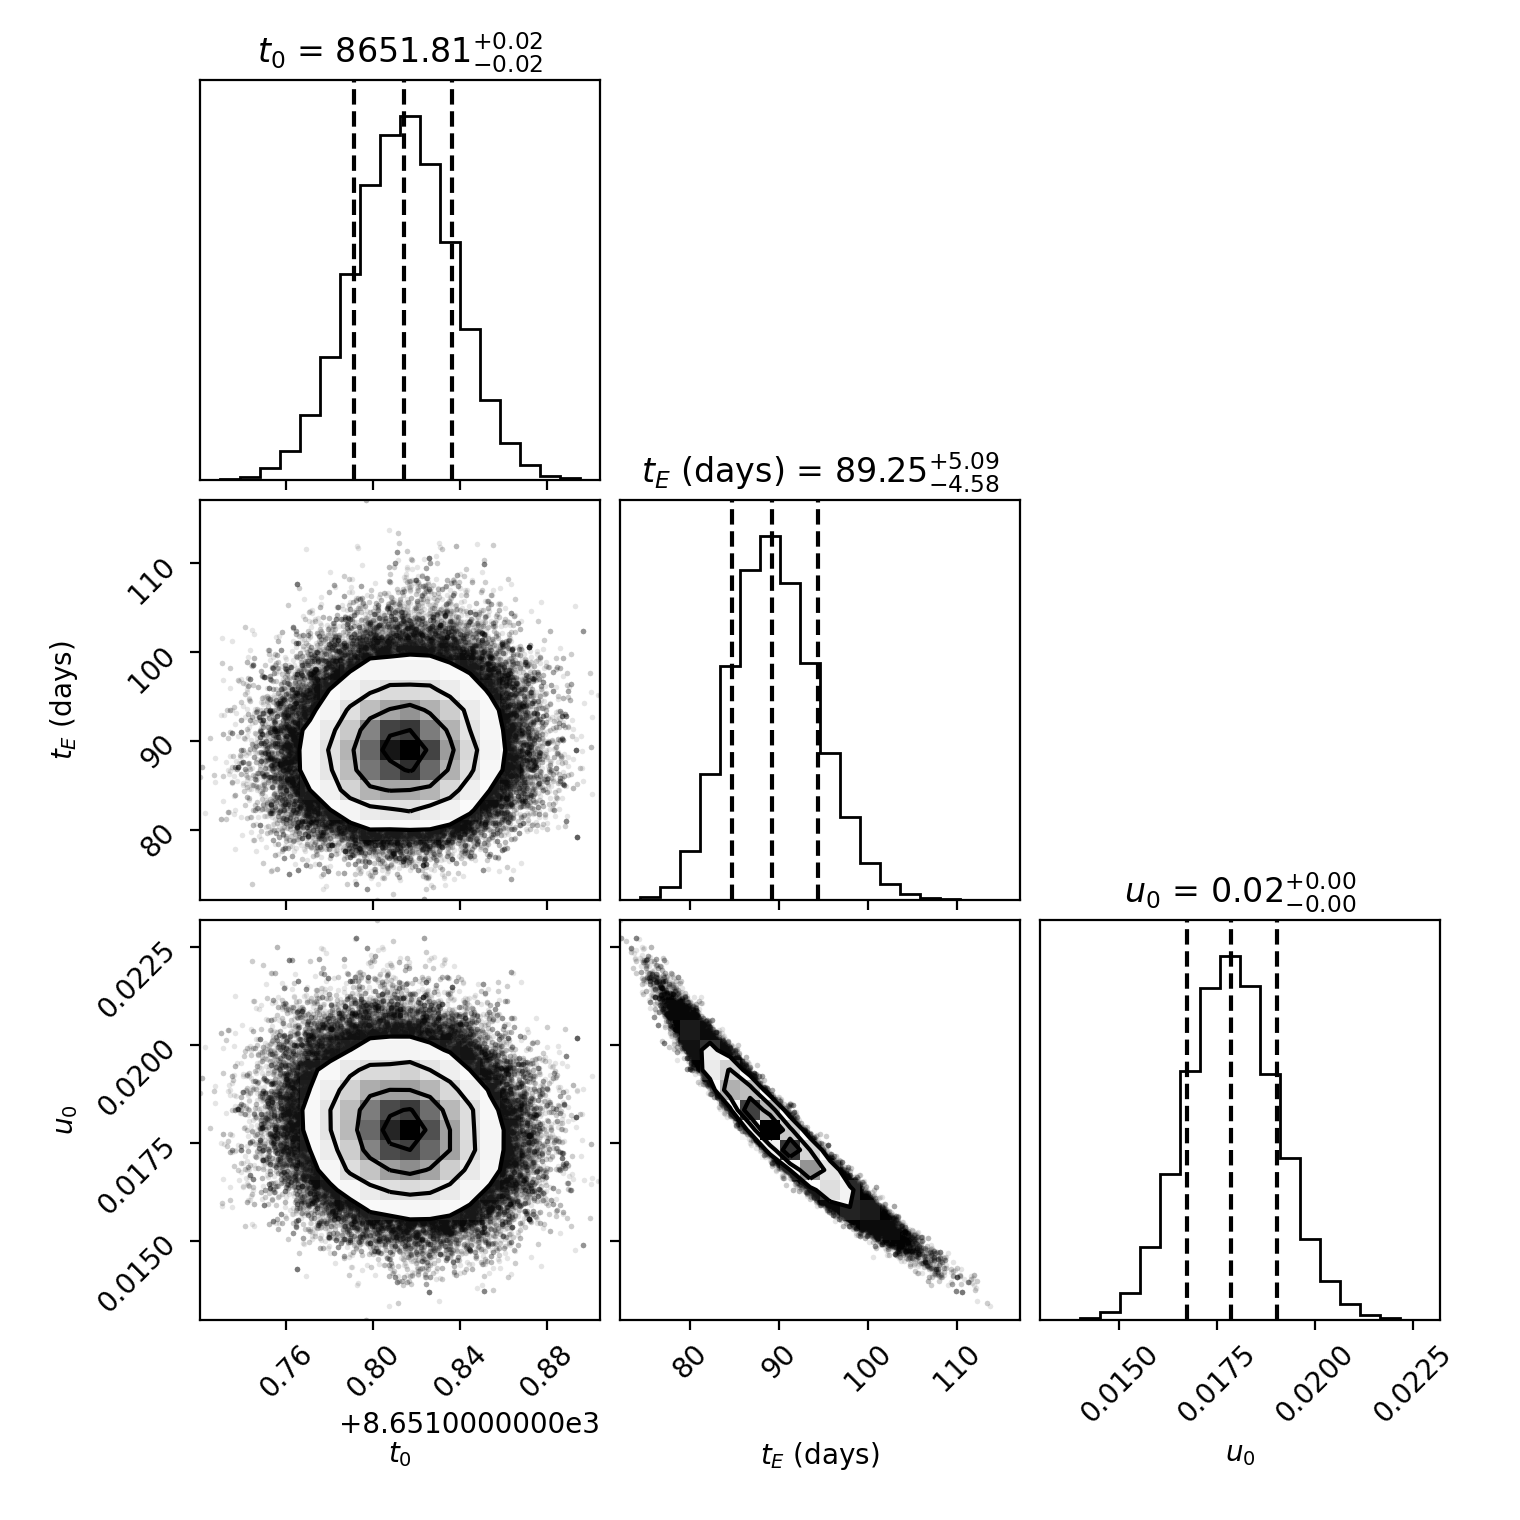

In [21]:
labels = ['$t_0$', '$t_E$ (days)', '$u_0$']

corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
)
plt.show()